<a href="https://colab.research.google.com/github/rodolfoarruda/MachineLearning/blob/main/Pratica_ProcImg_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ICMC - Instituto de Ciências Matemáticas e de Computação
## SCC5830 - Image Processing (2021)

# Rodolfo Augusto Da Silva Arruda - 6381848

### **Título:** Segmentação de lavoura de feijão, com relação à área coberta por vegetação, utilizando imagens coletadas via dispositivo de baixo custo e baixa altitude.

### **1- Introdução**

##### Segundo (Ponti et al, 2016) a obtenção de imagens via satélites é custosa e pode ser um limitador para estudar aplicações no campo da agricultura de precisão. Como alternativa, o pesquisador afirma que uma solução viável e de baixo custo é a utilização de sensoriamento remoto de baixa altitude, tal como o uso UAVs (veículos aéreos não tripulados) ou dirigíveis para coletar imagens, visando, por exemplo, estimar a produtividade, contar ervas daninhas ou o número de plantas.

##### No referido artigo, os autores utilizaram para os experimentos imagens deste tipo (baixo custo e baixa altitude) para estimar a área plantada de lavouras, as quaisi constituíram dois datasets. O primeiro sobre a cultura de feijões, coletado via um sistema que combina partes de um balão de hélio e uma pipa (Skyhook Helikite) e o segundo coletado via um UAV para coletar dados de cana de açúcar e eucalipto.

##### A identificação dos pixels das imagens com relação às duas classes (área com vegetação ou sem vegetação) foi obtida com auxílio de três especialistas da área de agronomia. A votação entre a opinião dos três constituiu a verdade absoluta com relação ao rótulo.


### **2- Material**

##### Para o propósito deste trabalho será utilizado o conjunto de dados sobre a lavoura de feijão, que é composto por 40 imagens coletadas em dois diferentes campos, sendo 18 de uma cultura mais produtiva (mais área com vegetação) e as 22 restantes de um campo menos produtivas, onde é maior a presença de plantas, ervas daninhas e solo. Todas as imagens foram coletadas a uma altura de 50 metros de altura, com o uso de um sistema dirigível e uma câmera de 10MP, com 24-bit RGB.

##### As imagens obtidas foram cortadas em quadrados de dimensão 512 × 512 pixels e armazenadas em formato PNG. O conjunto de dados final consiste em 29.556 exemplos da classe positiva (72,1% dos pixels) e 11.404 exemplos da classe negativa (27,9% dos pixels).



#### **2.1 - Setup**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Básicos
import numpy as np
import matplotlib.pyplot as plt

# Ler e salvar imagens
from skimage.io import imread_collection
from skimage.io import imsave
from skimage.io import imshow
import random

# Manipular imagem
import cv2

# Avaliação do modelo
from sklearn.metrics import f1_score

# Suprimir notação científica do Numpy
np.set_printoptions(suppress=True) 


#### **2.2 - Preparação dos dados**

#### **Partição do conjunto de dados** 
#### **Desenvolvimento:** 60% -- 24 imagens 
#### **Teste:** 20% -- 8 imagens          
#### **Validação:** 20% -- 8 imagens

In [72]:
np.random.seed(10)

list  = np.arange(1,41)
dev   = np.random.choice(list, 24, replace=False)
dev_compl = np.setdiff1d(list, dev)
test  = np.random.choice(dev_compl, 8, replace=False)
valid = np.setdiff1d(dev_compl, test)

In [73]:
print("Train:",dev);print("Test:",test);print("Valid:",valid)

Train: [ 3 28 36 31 15 14  8 25 32 13  6  7  4 22 21 35  2 19 12 38 24 17 20  5]
Test: [18 16 29  9 11 40 34  1]
Valid: [10 23 26 27 30 33 37 39]


##### Imagens

In [26]:
seq = imread_collection("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/suborbitalRS_40_check/*.png", conserve_memory=True)

In [30]:
for i in range(0,40):
  print(seq[i].shape)

(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)
(512, 512, 4)


In [ ]:
# Salvar conjunto dev:
for x in dev:
  imsave("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/img/imagem_" + str(x) + ".png",seq[x-1])

In [ ]:
# Salvar conjunto test:
for x in test:
  imsave("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/img/imagem_" + str(x) + ".png",seq[x-1])

In [ ]:
# Salvar conjunto valid:
for x in valid:
  imsave("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/valid/img/imagem_" + str(x) + ".png",seq[x-1])

##### Rótulos

In [182]:
rot = imread_collection("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/suborbitalRS_40_check/gt_full/*.png", conserve_memory=True)

In [183]:
# Correção para gray
for x in range(0,40):
  try:
    gray = cv2.cvtColor(rot[x], cv2.COLOR_RGB2GRAY)
    imsave("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/suborbitalRS_40_check/gt_full/trat/" + str(x) + ".png",gray)
  except:
    gray = rot[x]
    imsave("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/suborbitalRS_40_check/gt_full/trat/" + str(x) + ".png",gray)
    print("An exception occurred")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: /content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/suborbitalRS_40_check/gt_full/trat/0.png is a low contrast image
  """


An exception occurred
An exception occurred


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: /content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/suborbitalRS_40_check/gt_full/trat/12.png is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: /content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/suborbitalRS_40_check/gt_full/trat/14.png is a low contrast image
  """


An exception occurred
An exception occurred
An exception occurred
An exception occurred


In [184]:
rot = imread_collection("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/suborbitalRS_40_check/gt_full/trat/*.png", conserve_memory=True)

In [185]:
for i in range(0,40):
  print(rot[i].shape)

(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)


In [186]:
# Salvar rotulo dev:
for x in dev:
  imsave("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/rotulos/imagem_" + str(x) + ".png",rot[x-1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: /content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/rotulos/imagem_15.png is a low contrast image
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: /content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/rotulos/imagem_13.png is a low contrast image
  This is separate from the ipykernel package so we can avoid doing imports until


In [187]:
# Salvar rotulo test:
for x in test:
  imsave("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/rotulos/imagem_" + str(x) + ".png",rot[x-1])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: /content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/rotulos/imagem_1.png is a low contrast image
  This is separate from the ipykernel package so we can avoid doing imports until


In [188]:
# Salvar rotulo valid:
for x in valid:
  imsave("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/valid/rotulos/imagem_" + str(x) + ".png",rot[x-1])

### **3 - Proposta**

##### Os autores do artigo reportaram que as as principais técnicas utilizadas no estudo foram vegetation indices (ExG, CIVE e NDVI) e visual feature extractors (BIC e Haralick). Afirmaram que essas metodologias são frequentemente usadas em sensoriamento remoto para realizar segmentação ou para fornecer recursos que podem ser usados como entrada para métodos de agrupamento, classificação e regressão. Para a etapa de classificação foi utilizado o modelo SVM, com kernel RBF.

##### Com intuito de testar algumas abordagens diferentes sobre o mesmo problema existe a possibilidade avaliar se faz sentido utilizar outros extratores, sejam os tradicionais (cor, forma, textura) ou extratores do tipo deep features, com diferentes arquiteturas CNN (Inception, Resnet50, VGG16, EfficientNet, etc). A partir das características obtidas, verificar o desempenho de classificadores tradicionais (SVM, OPF, RF, etc) e comparar com o desempenho da classificação fim a fim (end2end) considerando diferentes arquiteturas CNNs, considerando diferentes métricas, como acurácia, especificidade, sensibilidade F1, tempos de extração, treinamento e classificação, dimensionalidade dos vetores de características e etc.

### **4 - Experimentos**

In [189]:
train = imread_collection("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/img/*.png", conserve_memory=False)
train_rot = imread_collection("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/rotulos/*.png", conserve_memory=False)

In [195]:
for i in range(0,24):
  print(train_rot[i].shape)

(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)
(512, 512)


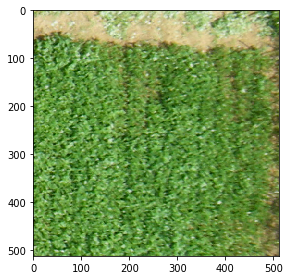

In [194]:
imshow(train[2]);

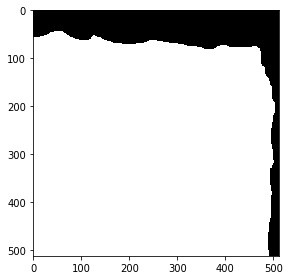

In [193]:
imshow(train_rot[2]);

### **4.1- Segmentação por limiar**

##### A ideia desta metodologia é encontrar um valor limiar com o qual, a partir dele, são definidas as classes da imagem. Ou seja, para o problema em questão (classificação binária), precisamos encontrar o melhor valor que indique que determinado pixel pertence à classe plantação (1 - branco) ou à classe terra (0 - preto)

###### **Exemplo:** Imagem 2

In [197]:
img = train[2]
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#gray = img
I0_opt1_mask = np.where(gray>150,0,1)
img_rot = train_rot[2]
#img_rot_gray = cv2.cvtColor(img_rot, cv2.COLOR_BGR2GRAY)
img_rot_gray = img_rot
img_rot_gray_mask = np.where(img_rot_gray>0,1,0)

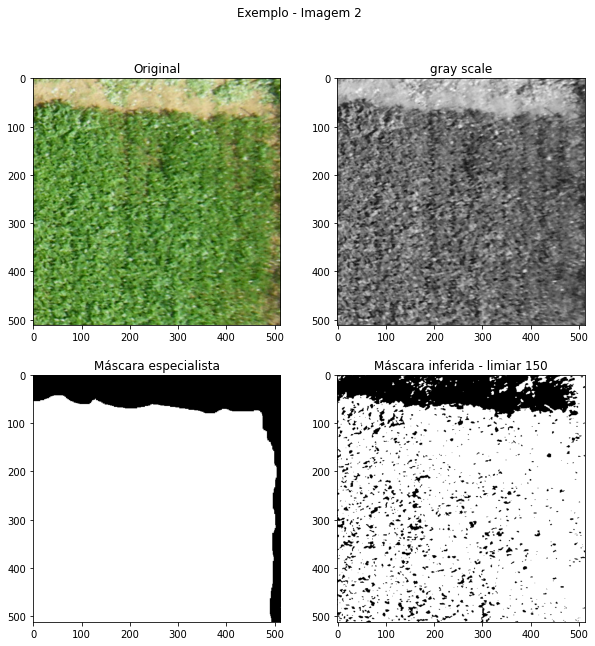

In [198]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

fig.set_figheight(10)
fig.set_figwidth(10)
fig.suptitle('Exemplo - Imagem 2')
ax1.imshow(img)
ax1.set_title('Original')
ax2.imshow(gray,cmap='gray')
ax2.set_title('gray scale')

ax3.imshow(img_rot_gray_mask,cmap='gray' )
ax3.set_title('Máscara especialista')

ax4.imshow(I0_opt1_mask,cmap='gray')
ax4.set_title('Máscara inferida - limiar 150');




### **Otimização**

##### Podemos criar uma função para determinar o valor ótimo desse limiar:

In [199]:
def max_f1(gt,gray):

  vec=np.arange(30,220,1)
  x = np.zeros(vec.size)
  max_x = np.array(30)
  max_f1 = np.array(0)

  j=0
  for i in vec:
    x[j] = f1_score(gt.ravel(), np.where(gray > i ,0,1).ravel(), average='macro')  
    if x[j] > max_f1: 
      max_f1 = x[j]
      max_x  = i
    j += 1

  return x , vec , max_x , max_f1


In [200]:
x, vec, limiar, max_f1 = max_f1(img_rot_gray_mask,gray)

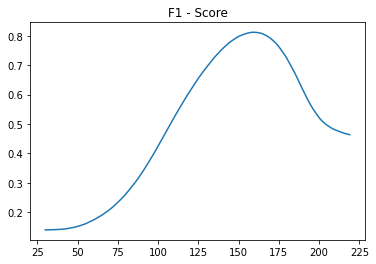

In [201]:
plt.plot(vec, x)
plt.title('F1 - Score');

In [202]:
print("O valor máximo de F1-Score:  {:.2f}".format(max_f1) , "é atingido no limiar:", limiar)

O valor máximo de F1-Score:  0.81 é atingido no limiar: 159


#### Extrapolação para todas as imagens

In [203]:
def max_f1_v2(gt,gray):

  vec=np.arange(30,220,5)
  x = np.zeros(vec.size)
  max_x = np.array(30)
  max_f1 = np.array(0)

  j=0
  for i in vec:
    x[j] = f1_score(gt.ravel(), np.where(gray > i ,0,1).ravel(), average='macro')  
    if x[j] > max_f1: 
      max_f1 = x[j]
      max_x  = i
    j += 1

  return max_x 


def seleciona_img(dados,rotulos):

  # Tratamento de dimensão, pois algumas imagens não tinham rótulos iguais a imagem
  s = 0
  for w in range(0,np.array(dados).shape[0]):
    if dados[s].shape[0] == 512:
      s += 1
  print(s)
  limiarx = np.zeros(s)
  for k in range(0,s):
    img = dados[k]
    img_rot = rotulos[k]
    if img.ndim > 2: 
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
      gray = img
    if img_rot.ndim > 2: 
      img_rot_gray = cv2.cvtColor(img_rot, cv2.COLOR_BGR2GRAY)
    else:
      img_rot_gray = img_rot
    img_rot_gray_mask = np.where(img_rot_gray>0,1,0)
    if rotulos[k].shape[0] == 512 and dados[k].shape[0] == 512:
      print(k)
      limiarx[k] = max_f1_v2(img_rot_gray_mask,gray)
  return np.median(limiarx)   

In [204]:
limiar_all = seleciona_img(train,train_rot)

24
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [205]:
print("O valor obtido foi de:", limiar_all)

O valor obtido foi de: 162.5


### Avaliando a imagem 2

In [206]:
f1_all = f1_score(img_rot_gray_mask.ravel(), np.where(gray > limiar_all ,0,1).ravel(), average='macro') 

In [207]:
print("O valor máximo de F1-Score:  {:.2f}".format(f1_all) , "é atingido no limiar:", limiar_all)

O valor máximo de F1-Score:  0.81 é atingido no limiar: 162.5


#### Outras imagens

In [208]:
img = train[5]
if img.ndim > 2: 
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
else:
  gray = img

I0_opt1_mask = np.where(gray>limiar_all,0,1)

img_rot = train_rot[5]

if img_rot.ndim > 2: 
  img_rot_gray = cv2.cvtColor(img_rot, cv2.COLOR_BGR2GRAY)
else:
  img_rot_gray = img_rot

img_rot_gray_mask = np.where(img_rot_gray>0,1,0)

f1_score(img_rot_gray_mask.ravel(), np.where(gray > limiar_all ,0,1).ravel(), average='macro') 

0.5067883515081002

### Avaliação no conjunto de teste

In [209]:
test = imread_collection("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/img/*.png", conserve_memory=True)
test_rot = imread_collection("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/test/rotulos/*.png", conserve_memory=True)


In [210]:
limiar_all = 162.5

# 8 imagens de teste!
f1 = np.zeros(8,dtype=np.float)

for i in range(0,np.size(f1)):
  
  img = test[i]
  if img.ndim > 2: 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  else:
    gray = img

  I0_opt1_mask = np.where(gray>limiar_all,0,1)

  img_rot = test_rot[i]

  if img_rot.ndim > 2: 
    img_rot_gray = cv2.cvtColor(img_rot, cv2.COLOR_BGR2GRAY)
  else:
    img_rot_gray = img_rot

  img_rot_gray_mask = np.where(img_rot_gray>0,1,0)

  f1[i] = f1_score(img_rot_gray_mask.ravel(), np.where(gray > limiar_all ,0,1).ravel(), average='macro') 
  print('F1-Score da image', i, ':', round(f1[i],2))

print('\n O valor médio do F1-Score foi de:', round(np.sum(f1)/np.size(f1),2))



F1-Score da image 0 : 0.49
F1-Score da image 1 : 0.58
F1-Score da image 2 : 0.6
F1-Score da image 3 : 0.54
F1-Score da image 4 : 0.57
F1-Score da image 5 : 0.58
F1-Score da image 6 : 0.59
F1-Score da image 7 : 0.62

 O valor médio do F1-Score foi de: 0.57


### **4.2 - Segmentação end2end deep learning**

In [ ]:
#!pip install git+https://github.com/qubvel/segmentation_models
#!pip install mahotas

     |████████████████████████████████| 5.7MB 6.9MB/s 


In [ ]:
%env SM_FRAMEWORK=tf.keras
import mahotas as mt
import keras 
import tensorflow as tf
keras.__version__
import segmentation_models as sm
keras.backend.set_image_data_format('channels_last')

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [5]:
import os

input_dir = "/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/img/"
target_dir = "/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/rotulos/"
img_size = (512, 512)
num_classes = 2
batch_size = 1

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 24
/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/img/imagem_12.png | /content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/rotulos/imagem_12.png
/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/img/imagem_13.png | /content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/rotulos/imagem_13.png
/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/img/imagem_14.png | /content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/rotulos/imagem_14.png
/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/img/imagem_15.png | /content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/rotulos/imagem_15.png
/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/img/imagem_17.png | /content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/rotulos/imagem_17.png
/content/drive/MyDrive/Doutorado/pesqu

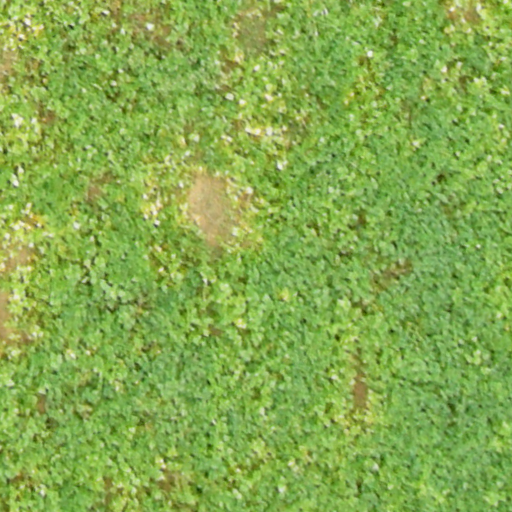

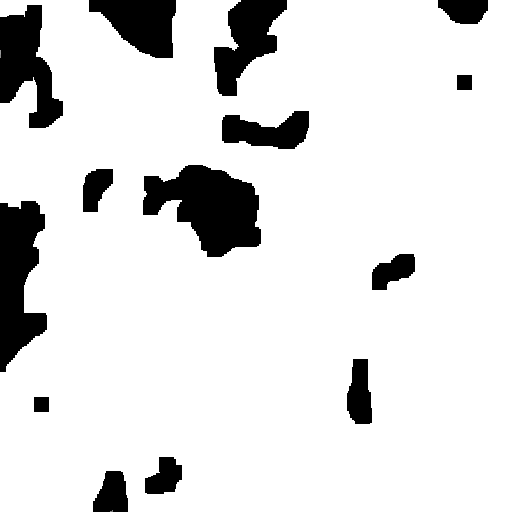

In [6]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[9]))
display(img)

In [7]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1
        return x, y

In [8]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
import random

# Split our img paths into a training and a validation set
val_samples = 7
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [10]:
val_gen

In [15]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer="rmsprop", loss="binary_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 10
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/10
17/17 [==============================] - 6s 124ms/step - loss: -11541381120.0000 - val_loss: -119717552128.0000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
17/17 [==============================] - 2s 95ms/step - loss: -152483938304.0000 - val_loss: -1028313251840.0000
Epoch 3/10
17/17 [==============================] - 2s 97ms/step - loss: -922096041984.0000 - val_loss: -4641465040896.0000
Epoch 4/10
17/17 [==============================] - 2s 94ms/step - loss: -3687052214272.0000 - val_loss: -16921001984000.0000
Epoch 5/10
17/17 [==============================] - 2s 95ms/step - loss: -11427448356864.0000 - val_loss: -36212022706176.0000
Epoch 6/10
17/17 [==============================] - 2s 95ms/step - loss: -29935357919232.0000 - val_loss: -91643243921408.0000
Epoch 7/10
17/17 [==============================] - 2s 95ms/step - loss: -69329932517376.0000 - val_loss: -181776555180032.0000
Epoch 8/10
17/17 [==============================] - 2s 96ms/step - loss: -146325156921344.0000 - val_loss: -388950728376320.0000
Epoch 9/10
17/17 [==============================] - 2s 95ms/step - loss: -286839927734272.0000 - val_loss: -7713017

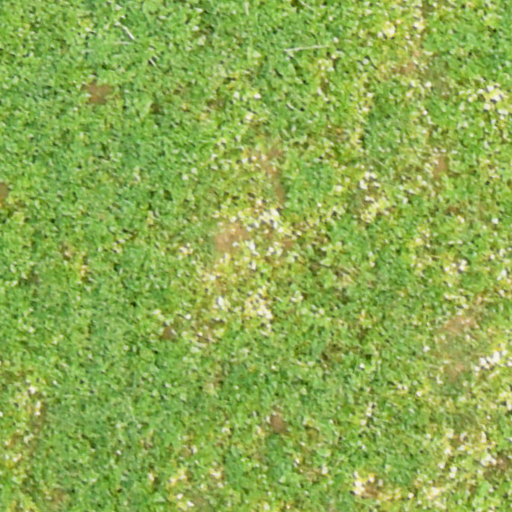

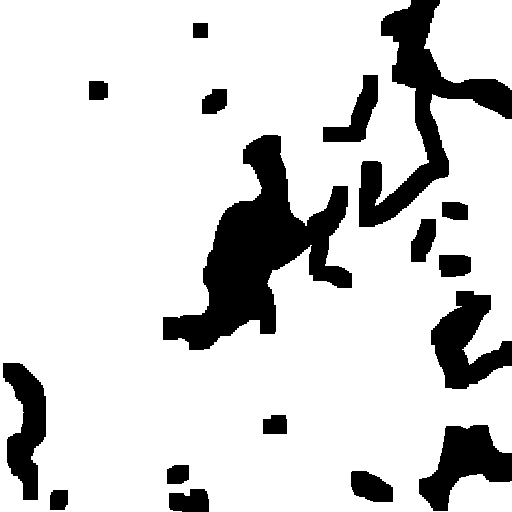

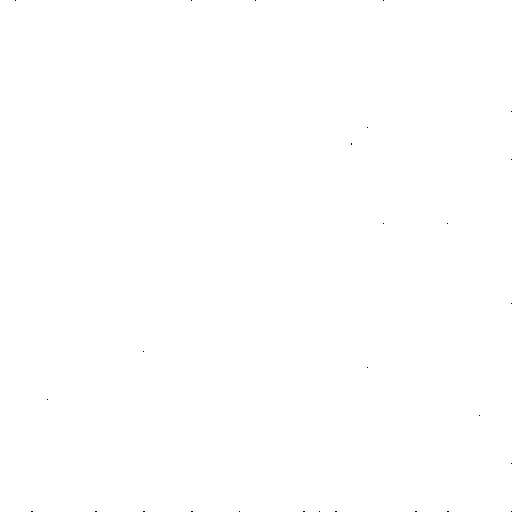

In [16]:
# Generate predictions for all images in the validation set

val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 1

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

#### **3.1 - Extratores tradicionais**

In [ ]:
train = imread_collection("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/img/*.png", conserve_memory=True)
train_rot = imread_collection("/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/rotulos/*.png", conserve_memory=True)

In [ ]:
i = 1

img = train[i]
if img.ndim > 2: 
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
else:
  gray = img

img_rot = train_rot[i]

if img_rot.ndim > 2: 
  img_rot_gray = cv2.cvtColor(img_rot, cv2.COLOR_BGR2GRAY)
else:
  img_rot_gray = img_rot

img_rot_gray_mask = np.where(img_rot_gray>0,0,1)


/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


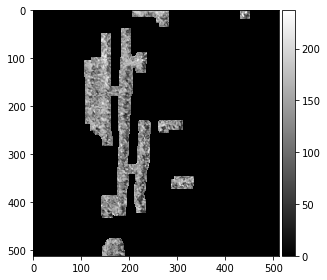

In [ ]:
imshow(gray*img_rot_gray_mask,cmap='gray')

In [ ]:
aa = gray*img_rot_gray_mask

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


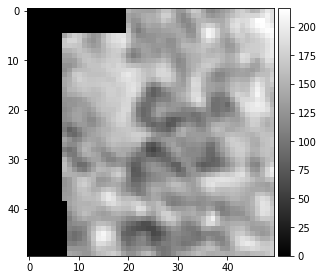

In [ ]:
imshow(aa[100:150,100:150],cmap='gray');

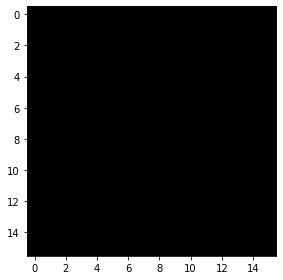

In [ ]:
i=15
j=5
imshow(aa[i*16:16+i*16,j*16:16+j*16]);

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


AttributeError: ignored

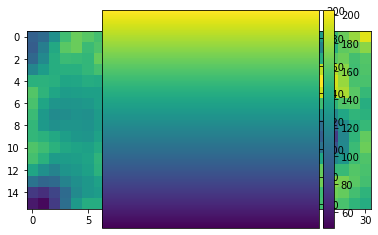

In [ ]:
for i in range(1,32):
  #print(i)
  imshow(aa[i*16:16+i*16,i:16+i*16])

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


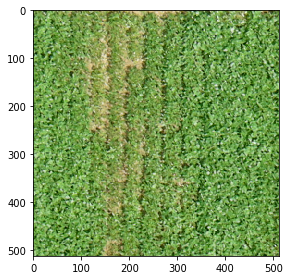

In [ ]:
imshow(train[1]);

##### **3.1.1. Haralick**  

###### Descritores que caracterizam matrizes de co-ocorrência são chamados de descritores de Haralick pelo método ter sido proposto por Robert Haralick (Haralick et al. 1973)

In [ ]:
!pip install git+https://github.com/ProfBressan/FeatureExtraction

  Cloning https://github.com/ProfBressan/FeatureExtraction to /tmp/pip-req-build-4zqm2v71
  Running command git clone -q https://github.com/ProfBressan/FeatureExtraction /tmp/pip-req-build-4zqm2v71
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.


In [ ]:
class Haralick:
	def __init__(self):
		self.image_path = ''
	def setImagePath(self, image_path):
		self.image_path = image_path
	def getImagePath(self):
		return self.image_path
	def extractionFeatures(self, image_path):
		try:
			self.image_path = image_path
			img = Image.open(self.image_path)
			imgRGB = img.convert('RGB')
			imgGray = imgRGB.convert('L')
			textures = mt.features.haralick(np.asanyarray(imgGray))
			ht_mean = textures.mean(axis=0)
			return ht_mean
		except Exception as e:
			print('\n################# (haralick) - Error Reading Image!  #################\n', e)

In [ ]:
from PIL import Image

img = Image.open('/content/drive/MyDrive/Doutorado/pesquisa/03_experimentos/amostras/train/img/imagem_5.png')
imgRGB = img.convert('RGB')
imgGray = imgRGB.convert('L')

array_p = np.asanyarray(imgGray)[0:15,0:15]

textures = mt.features.haralick(array_p)
ht_mean = textures.mean(axis=0)


In [ ]:
ht_mean

array([ 2.74385094e-03,  3.24686480e+02,  7.76460116e-01,  7.27756740e+02,
        6.64178919e-02,  2.16979507e+02,  2.58634048e+03,  6.77940997e+00,
        8.56294707e+00,  1.84640042e-04,  4.96937993e+00, -6.52045307e-01,
        9.99873050e-01])

In [ ]:
imgRGB = img.convert('RGB')
imgGray = imgRGB.convert('L')
a = mt.features.haralick(train[1][0:15,0:15])

In [ ]:
a

array([[ 6.30583900e-02,  1.32427381e+02,  9.87617427e-01,
         5.34732906e+03,  3.24371337e-01,  2.86229762e+02,
         2.12568889e+04,  6.67363068e+00,  8.36304182e+00,
         3.78089957e-04,  4.23392198e+00, -6.34240271e-01,
         9.99788314e-01],
       [ 6.30637300e-02,  2.75062500e+02,  9.73975818e-01,
         5.28474824e+03,  3.05990841e-01,  2.87743622e+02,
         2.08639304e+04,  6.68971482e+00,  8.33379401e+00,
         3.39360299e-04,  4.64432383e+00, -6.36415467e-01,
         9.99790792e-01],
       [ 6.30321712e-02,  1.90764286e+02,  9.81972799e-01,
         5.29101223e+03,  3.19943681e-01,  2.88150000e+02,
         2.09732846e+04,  6.65752509e+00,  8.40502356e+00,
         3.57584359e-04,  4.41630406e+00, -6.26352567e-01,
         9.99765496e-01],
       [ 6.30783723e-02,  2.89584184e+02,  9.72614273e-01,
         5.28713708e+03,  2.91865922e-01,  2.87737245e+02,
         2.08589641e+04,  6.60038105e+00,  8.31208540e+00,
         3.21248033e-04,  4.66193085e

In [ ]:
train[1].shape

(512, 512, 4)

In [ ]:
a

array([[ 6.25607185e-02,  2.13113169e+02,  9.80183002e-01,
         5.37702952e+03,  3.11314564e-01,  2.96799550e+02,
         2.12950049e+04,  7.19476279e+00,  1.09948169e+01,
         3.46551930e-04,  4.55620183e+00, -2.98148185e-01,
         9.89328418e-01],
       [ 6.25460880e-02,  3.86314629e+02,  9.64070943e-01,
         5.37607533e+03,  2.97403366e-01,  2.96821124e+02,
         2.11179867e+04,  7.17978127e+00,  1.12930267e+01,
         3.18138751e-04,  4.88870325e+00, -2.51972483e-01,
         9.80533739e-01],
       [ 6.25597282e-02,  2.22112978e+02,  9.79342882e-01,
         5.37618518e+03,  3.10565226e-01,  2.96842383e+02,
         2.12826277e+04,  7.19397631e+00,  1.10169535e+01,
         3.44877846e-04,  4.57849048e+00, -2.94792642e-01,
         9.88854664e-01],
       [ 6.25451529e-02,  4.06133757e+02,  9.62227654e-01,
         5.37607276e+03,  2.96785662e-01,  2.96821241e+02,
         2.10981573e+04,  7.17797779e+00,  1.13165211e+01,
         3.16473601e-04,  4.91504699e

### Módulos Modeleagem

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


# Referências
### https://github.com/qubvel/segmentation_models
### https://github.com/ProfBressan/FeatureExtraction

### Ponti, M. et al. "Precision Agriculture: using low-cost systems to acquire low-altitude images". IEEE Computer Graphics and Applications, 2016.
